In [1]:
#@title Install libraries
#Install required libraries.
!pip install --upgrade pip -q
!pip install scikit-allel -q
!pip install biopython -q
!pip install ipytree -q
!pip install numcodecs -q
!pip install rfpimp -q
!pip install --upgrade setuptools wheel -q
!pip install --upgrade "mxnet<2.0.0" -q
!pip install autogluon -q
!pip install pyod -q
!pip install phik -q

In [21]:
#@title Import necessary libraries
#Import necessary libraries
##General data analysis libraries
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import mannwhitneyu
import gzip
from pathlib import Path
##Data Viz libraries
import seaborn as sns
import matplotlib.pyplot as plt
##ML-related libraries
from sklearn.linear_model import LogisticRegressionCV, LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error, balanced_accuracy_score
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pyod.utils.data import evaluate_print
import autogluon
from pyod.models.copod import COPOD
from pyod.models.iforest import IForest
import phik
from phik import resources, report
##Ignore any warnings
import warnings
warnings.filterwarnings('ignore')

## 0. Setup datasets

In [3]:
#Specify data folder path - in Google Drive
DATA = Path('/content/drive/MyDrive/000_Personal_Projects/014_Genomics/ecbme4060/final project/data')

In [4]:
## Read GDSC (Genomic Data Sensitivity in Cancer) database. 
gdsc_filtered = pd.read_excel(DATA/'GDSC1_fitted_dose_response_25Feb20.xlsx')

#Obtain the IC50 score from the natural log of IC50 column. 
gdsc_filtered['IC50'] = gdsc_filtered['LN_IC50'].apply(lambda LN_IC50: np.exp(LN_IC50)) 
gdsc_filtered.head()

,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE,IC50
0,GDSC1,281,12974350,683665,MC-CAR,SIDM00636,MM,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2.0,2.395685,0.982114,0.022521,-0.189576,10.975714
1,GDSC1,281,12975300,684055,ES3,SIDM00265,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2.0,3.140923,0.984816,0.031840,0.508635,23.125202
2,GDSC1,281,12975647,684057,ES5,SIDM00263,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2.0,3.968757,0.985693,0.026052,1.284229,52.918712
3,GDSC1,281,12975980,684059,ES7,SIDM00269,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2.0,2.692768,0.972699,0.110056,0.088760,14.772510
4,GDSC1,281,12976330,684062,EW-11,SIDM00203,UNCLASSIFIED,1,Erlotinib,EGFR,EGFR signaling,1045,Y,0.007813,2.0,2.478678,0.944462,0.087011,-0.111820,11.925488


In [5]:
#Filter out only cisplatin related drug sensitivity scores. 
gdsc_cisplatin = gdsc_filtered[gdsc_filtered.DRUG_NAME == 'Cisplatin']

#Calculate drug efficacy cutoffs 
gdsc_iq50_q1 = np.percentile(gdsc_cisplatin['IC50'].tolist(), 25, interpolation = 'midpoint')
gdsc_iq50_q3 = np.percentile(gdsc_cisplatin['IC50'].tolist(), 75, interpolation = 'midpoint')
gdsc_iq50_iqr = stats.iqr(gdsc_cisplatin['IC50'].tolist(), interpolation = 'midpoint')
gdsc_upper_outlier_value = gdsc_iq50_q3 + 1.5*gdsc_iq50_iqr
gdsc_lower_outlier_value = gdsc_iq50_q1 - 1.5*gdsc_iq50_iqr

#Flag cell lines that meet the condition for poor and good drug efficacy scores.
gdsc_cisplatin['drug_efficacy'] = gdsc_cisplatin['IC50'].apply(lambda x: 'poor' if x >= gdsc_upper_outlier_value else ('good' if x < gdsc_lower_outlier_value else 'standard'))

#Check how many cell lines have poor drug efficacy.
gdsc_cisplatin.drug_efficacy.value_counts()

standard    1718
poor         161
Name: drug_efficacy, dtype: int64

---

In [6]:
##Read in COSMIC mutation data. 
#The COSMIC mutation data has already been filtered out for cisplatin-related cell lines to save memory. 
cosmic_mutation_data_cisplatin = pd.read_csv(DATA/'cosmic_mutation_data_cisplatin.csv')
cosmic_mutation_data_cisplatin = cosmic_mutation_data_cisplatin[['gene', 'ID_sample', 'GENOMIC_MUTATION_ID', 'LEGACY_MUTATION_ID', 'Mutation genome position']]

#Drop any duplicates (often mutations are double listed on gene variants that are listed differently)
cosmic_mutation_data_cisplatin = cosmic_mutation_data_cisplatin.drop_duplicates()
cosmic_mutation_data_cisplatin.head(2)

,gene,ID_sample,GENOMIC_MUTATION_ID,LEGACY_MUTATION_ID,Mutation genome position
0,ZBTB20,908474,COSV61876228,COSN14023900,3:114930842-114930842
1,PCDHGA2,722066,COSV52766690,COSM1194395,5:141478485-141478485


## 1. Check if there is a correlation between drug efficacy and number of mutations

In [7]:
#Make dataframe of number of mutations in each cell line sample. 
mutation_count = pd.DataFrame(cosmic_mutation_data_cisplatin.ID_sample.value_counts()).reset_index()
mutation_count = mutation_count.merge(gdsc_cisplatin[['COSMIC_ID', 'IC50', 'drug_efficacy']], left_on='index', right_on='COSMIC_ID',how='left')
mutation_count['poor_drug_efficacy'] = mutation_count['drug_efficacy'].apply(lambda x: True if x == 'poor' else False)
mutation_count.head()

,index,ID_sample,COSMIC_ID,IC50,drug_efficacy,poor_drug_efficacy
0,1659823,52597,1659823,60.929046,poor,True
1,906831,32180,906831,40.862346,standard,False
2,906831,32180,906831,3.849884,standard,False
3,905971,30215,905971,16.001893,standard,False
4,905971,30215,905971,2.409172,standard,False


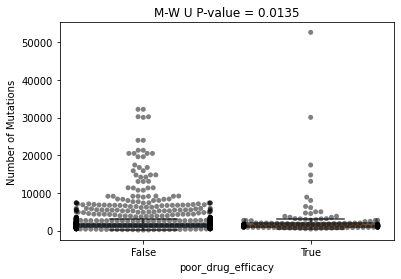

In [8]:
#Conduct mann-whitney u test to test correlation between number of mutations and drug efficacy. 
mwu, pval = mannwhitneyu(mutation_count.loc[mutation_count.poor_drug_efficacy, "ID_sample"],
                         mutation_count.loc[~mutation_count.poor_drug_efficacy, "ID_sample"],
                         alternative = 'greater')
#Plot results.
ax = sns.boxplot(x="poor_drug_efficacy", y="ID_sample", data=mutation_count, fliersize=0)
ax = sns.swarmplot(x="poor_drug_efficacy", y="ID_sample", data=mutation_count, color="k",
                  alpha=0.5, ax=ax)
ax.set_title("M-W U P-value = {}".format(np.round(pval, 4)))
ax.set_ylabel('Number of Mutations')
plt.show()

With this one-sided mann-whitney u test, we can conclude that there is a statistically significant correlation between the number of mutations in the cell line and drug efficacy. 
Next, see if there is a stronger correlation between the number of mutations in genes that are enzymes, targets, carriers, or transporters of Cisplatin.

In [9]:
#Filter for Cisplatin related genes.
related_genes = ['DNA', 'MPG', 'A2M', 'TF', 'ATOX1', 'MPO', 'XDH', 'CYP4A11', 'PTGS2', 'NAT', 'CYP2C9', 'CYP2B6', 'BCHE', 'GSTT1', 'MT1A', 'MT2A', 'SOD1', 'GSTP1', 'NQO1', 'GSTM1']
cosmic_mutation_data_cisplatin_filtered = cosmic_mutation_data_cisplatin[cosmic_mutation_data_cisplatin['gene'].isin(related_genes)]
#Remake mutation count dataframe
#Check counts for each cell
mutation_count = pd.DataFrame(cosmic_mutation_data_cisplatin_filtered.ID_sample.value_counts()).reset_index()
mutation_count = mutation_count.merge(gdsc_cisplatin[['COSMIC_ID', 'IC50', 'drug_efficacy']], left_on='index', right_on='COSMIC_ID',how='left')

#Make Binary column (to conduct u-test)
mutation_count['poor_drug_efficacy'] = mutation_count['drug_efficacy'].apply(lambda x: True if x == 'poor' else False)

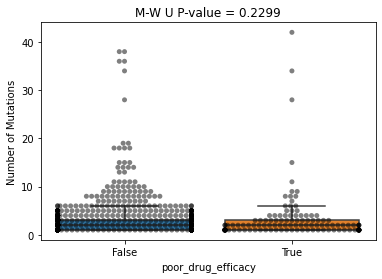

In [10]:
#Conduct mann-whitney u test to test correlation between number of mutations and drug efficacy. 
mwu, pval = mannwhitneyu(mutation_count.loc[mutation_count.poor_drug_efficacy, "ID_sample"],
                         mutation_count.loc[~mutation_count.poor_drug_efficacy, "ID_sample"],
                         alternative = 'greater')
#Plot results.
ax = sns.boxplot(x="poor_drug_efficacy", y="ID_sample", data=mutation_count, fliersize=0)
ax = sns.swarmplot(x="poor_drug_efficacy", y="ID_sample", data=mutation_count, color="k",
                  alpha=0.5, ax=ax)
ax.set_title("M-W U P-value = {}".format(np.round(pval, 4)))
ax.set_ylabel('Number of Mutations')
plt.show()

There is no significant correlation between the number of mutations in related genes and the drug efficacy. 

##2. Conduct logistic regression

To conduct the logistic regression, we first filtered the mutations to reduce the number of variables in the model. To filter the mutations, we used the same methods as above - filtering for mutations in genes related to Cisplatin. 

In [11]:
#Make dataframe of counts of each mutation in each cell line. 
mutation_count_df = cosmic_mutation_data_cisplatin_filtered.groupby(["ID_sample", 'GENOMIC_MUTATION_ID'], as_index=False)['LEGACY_MUTATION_ID'].count().pivot('ID_sample', 'GENOMIC_MUTATION_ID').fillna(0)
mutation_count_df.head(2)

LEGACY_MUTATION_ID               ...                          
GENOMIC_MUTATION_ID       COSV51856922 COSV51856925  ... COSV66993085 COSV66993089
ID_sample                                            ...                          
683665                             0.0          0.0  ...          0.0          0.0
683667                             0.0          0.0  ...          0.0          0.0

[2 rows x 1692 columns]

In [12]:
#Merge mutation data with the drug efficacy data. 
gdsc_cisplatin_filtered = gdsc_cisplatin[['COSMIC_ID', 'CELL_LINE_NAME', 'SANGER_MODEL_ID','DRUG_ID', 'DRUG_NAME', 'AUC', 'IC50', 'drug_efficacy']]
cosmic_mutation_data_cisplatin_merged = mutation_count_df.merge(gdsc_cisplatin_filtered, left_on='ID_sample', right_on='COSMIC_ID', how='left').reset_index(drop=True)
cosmic_mutation_data_cisplatin_merged.columns = cosmic_mutation_data_cisplatin_merged.columns.map(lambda x: str(x).replace('(LEGACY_MUTATION_ID, ','').replace(')', ''))
cosmic_mutation_data_cisplatin_merged.head()

,"('LEGACY_MUTATION_ID', 'COSV51856922'","('LEGACY_MUTATION_ID', 'COSV51856925'","('LEGACY_MUTATION_ID', 'COSV51857081'","('LEGACY_MUTATION_ID', 'COSV51857221'","('LEGACY_MUTATION_ID', 'COSV51857402'","('LEGACY_MUTATION_ID', 'COSV51857409'","('LEGACY_MUTATION_ID', 'COSV51857416'","('LEGACY_MUTATION_ID', 'COSV51857550'","('LEGACY_MUTATION_ID', 'COSV51857565'","('LEGACY_MUTATION_ID', 'COSV51858032'","('LEGACY_MUTATION_ID', 'COSV51858381'","('LEGACY_MUTATION_ID', 'COSV51858786'","('LEGACY_MUTATION_ID', 'COSV51858921'","('LEGACY_MUTATION_ID', 'COSV51858950'","('LEGACY_MUTATION_ID', 'COSV51859023'","('LEGACY_MUTATION_ID', 'COSV51859463'","('LEGACY_MUTATION_ID', 'COSV51859705'","('LEGACY_MUTATION_ID', 'COSV51859780'","('LEGACY_MUTATION_ID', 'COSV51859903'","('LEGACY_MUTATION_ID', 'COSV51860040'","('LEGACY_MUTATION_ID', 'COSV51860044'","('LEGACY_MUTATION_ID', 'COSV51860847'","('LEGACY_MUTATION_ID', 'COSV51861543'","('LEGACY_MUTATION_ID', 'COSV51861572'","('LEGACY_MUTATION_ID', 'COSV51861723'","('LEGACY_MUTATION_ID', 'COSV51862184'","('LEGACY_MUTATION_ID', 'COSV51862294'","('LEGACY_MUTATION_ID', 'COSV51862990'","('LEGACY_MUTATION_ID', 'COSV51862999'","('LEGACY_MUTATION_ID', 'COSV51863362'","('LEGACY_MUTATION_ID', 'COSV51863416'","('LEGACY_MUTATION_ID', 'COSV51863421'","('LEGACY_MUTATION_ID', 'COSV51863568'","('LEGACY_MUTATION_ID', 'COSV51863618'","('LEGACY_MUTATION_ID', 'COSV51863681'","('LEGACY_MUTATION_ID', 'COSV51863691'","('LEGACY_MUTATION_ID', 'COSV51863766'","('LEGACY_MUTATION_ID', 'COSV51863790'","('LEGACY_MUTATION_ID', 'COSV51863831'","('LEGACY_MUTATION_ID', 'COSV51863848'",...,"('LEGACY_MUTATION_ID', 'COSV66572743'","('LEGACY_MUTATION_ID', 'COSV66992216'","('LEGACY_MUTATION_ID', 'COSV66992223'","('LEGACY_MUTATION_ID', 'COSV66992245'","('LEGACY_MUTATION_ID', 'COSV66992253'","('LEGACY_MUTATION_ID', 'COSV66992262'","('LEGACY_MUTATION_ID', 'COSV66992274'","('LEGACY_MUTATION_ID', 'COSV66992291'","('LEGACY_MUTATION_ID', 'COSV66992296'","('LEGACY_MUTATION_ID', 'COSV66992329'","('LEGACY_MUTATION_ID', 'COSV66992346'","('LEGACY_MUTATION_ID', 'COSV66992352'","('LEGACY_MUTATION_ID', 'COSV66992398'","('LEGACY_MUTATION_ID', 'COSV66992517'","('LEGACY_MUTATION_ID', 'COSV66992561'","('LEGACY_MUTATION_ID', 'COSV66992578'","('LEGACY_MUTATION_ID', 'COSV66992673'","('LEGACY_MUTATION_ID', 'COSV66992689'","('LEGACY_MUTATION_ID', 'COSV66992697'","('LEGACY_MUTATION_ID', 'COSV66992718'","('LEGACY_MUTATION_ID', 'COSV66992755'","('LEGACY_MUTATION_ID', 'COSV66992770'","('LEGACY_MUTATION_ID', 'COSV66992810'","('LEGACY_MUTATION_ID', 'COSV66992814'","('LEGACY_MUTATION_ID', 'COSV66992824'","('LEGACY_MUTATION_ID', 'COSV66992919'","('LEGACY_MUTATION_ID', 'COSV66993054'","('LEGACY_MUTATION_ID', 'COSV66993058'","('LEGACY_MUTATION_ID', 'COSV66993068'","('LEGACY_MUTATION_ID', 'COSV66993076'","('LEGACY_MUTATION_ID', 'COSV66993085'","('LEGACY_MUTATION_ID', 'COSV66993089'",COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,DRUG_ID,DRUG_NAME,AUC,IC50,drug_efficacy
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,683665,MC-CAR,SIDM00636,1005,Cisplatin,0.934709,16.385356,standard
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,683665,MC-CAR,SIDM00636,1496,Cisplatin,0.935993,5.016222,standard
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,683667,PFSK-1,SIDM

In [13]:
#Split train and test data. Use only the mutation data in training data, and drug efficacy data in test data.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cosmic_mutation_data_cisplatin_merged.iloc[:, :-8], 
                                                    cosmic_mutation_data_cisplatin_merged.iloc[:, -1], 
                                                    test_size=0.25, 
                                                    random_state=42)

In [14]:
#Run logistic regression
#Given there are a lot less poor efficacy cell lines, class weight balanced.
lr = LogisticRegressionCV(cv=5, penalty='l2', class_weight = 'balanced')
lr.fit(X_train, y_train)

y_pred_score = lr.predict_proba(X_test)
y_pred = lr.predict(X_test)

In [15]:
def performance_scores(y_true, y_pred_score, y_pred=None):
    # Use performance score function from class. 
    if y_pred is None:
        y_pred = y_pred_score.argmax(axis=1)
        
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        #"auroc": roc_auc_score(y_true, y_pred_score, average="weighted",
         #                      multi_class="ovr"),
        "f1": f1_score(y_true, y_pred, average="weighted")
    }

In [16]:
performance_scores(y_test, y_pred_score, y_pred)

{'accuracy': 0.8839285714285714,
 'balanced_accuracy': 0.5164473684210527,
 'f1': 0.8575231475368275}

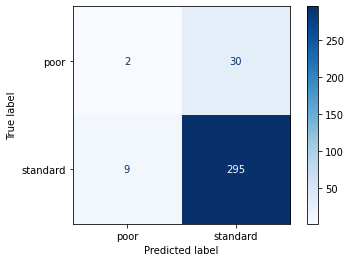

In [17]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=lr.classes_)
disp.plot(cmap="Blues")

In [25]:
#Obtain list of coefficients for the features. 
logistic_regression_coef = pd.DataFrame(zip(X_train.columns, np.transpose(lr.coef_)), columns=['features', 'coef']) 

## 3. Conduct Outlier Detection

In [18]:
cosmic_mutation_data_cisplatin_merged['drug_efficacy'] = cosmic_mutation_data_cisplatin_merged['drug_efficacy'].apply(lambda x: 1 if x=='poor' else 0)
X_train, X_test, y_train, y_test = train_test_split(cosmic_mutation_data_cisplatin_merged.iloc[:, :-8], 
                                                    cosmic_mutation_data_cisplatin_merged.iloc[:, -1], 
                                                    test_size=0.25, 
                                                    random_state=42)

In [22]:
## Implement Isolation Forest
clf = IForest(contamination=0.1)
clf.fit(X_train)

y_train_scores = clf.decision_scores_  # raw outlier scores on the train data
y_test_scores = clf.decision_function(X_test)  # predict raw outlier scores on test

y_test_pred, y_test_pred_confidence = clf.predict(X_test, return_confidence=True) 

print("On Training Data:")
evaluate_print(clf, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf, y_test, y_test_scores)

On Training Data:
IForest(behaviour='old', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
    verbose=0) ROC:0.5071, precision @ rank n:0.1264

On Test Data:
IForest(behaviour='old', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
    verbose=0) ROC:0.5045, precision @ rank n:0.0938


In [23]:
## Implement COPOD
clf = COPOD(contamination=0.1)
clf.fit(X_train)

y_train_scores = clf.decision_scores_
y_test_scores = clf.decision_function(X_test) 

y_test_pred, y_test_pred_confidence = clf.predict(X_test, return_confidence=True) 

print("\nOn Training Data:")
evaluate_print(clf, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf, y_test, y_test_scores)


On Training Data:
COPOD(contamination=0.1, n_jobs=1) ROC:0.4957, precision @ rank n:0.1279

On Test Data:
COPOD(contamination=0.1, n_jobs=1) ROC:0.5745, precision @ rank n:0.0625


## 4. Understanding the Effects of Multiple Variants

In [34]:
import phik
from phik import resources, report

In [50]:
#Find top 5 variants
logistic_regression_coef['features'] = logistic_regression_coef['features'].apply(lambda x: x.replace("('LEGACY_MUTATION_ID', ", "").replace("'", ''))
top_variants = logistic_regression_coef.sort_values(by='coef', ascending=False)[:5]
top_variants.head()

,features,coef
318,COSV53920751,[0.02541817333660995]
691,COSV57842518,[0.01914645838696113]
1572,COSV66568196,[0.017593729587332733]
1579,COSV66568511,[0.015942686835584897]
186,COSV53248212,[0.014418612525770936]


In [51]:
cosmic_mutation_data_cisplatin_merged.columns = cosmic_mutation_data_cisplatin_merged.columns.map(lambda x: x.replace("('LEGACY_MUTATION_ID', ", "").replace("'", ''))

In [53]:
#Make correlation matrix
correlations = cosmic_mutation_data_cisplatin_merged.corr()[top_variants['features'].tolist()]

In [84]:
#Make list of mutation and the most correlated mutations with each mutation. 
variants = []
for variant in top_variants['features'].tolist():
  print(variant, list(correlations[variant].sort_values(ascending=False).index[1:6]))
  variants.extend(list(correlations[variant].sort_values(ascending=False).index[:6]))

COSV53920751 ['COSV53923609', 'COSV54739935', 'COSV54739951', 'COSV65151917', 'COSV66572623']
COSV57842518 ['COSV57731032', 'COSV56561277', 'COSV53246543', 'COSV65147911', 'COSV65147908']
COSV66568196 ['COSV54255750', 'COSV65147638', 'COSV53919556', 'COSV52253236', 'COSV52263838']
COSV66568511 ['COSV65151810', 'COSV59394522', 'COSV52254822', 'COSV52260977', 'COSV57842518']
COSV53248212 ['COSV53924379', 'COSV57733194', 'COSV53925443', 'COSV54738071', 'COSV56563368']
